# PAA - Songs Recommendation
<br>

Este projeto tem como objetivos recomendar ao usuário músicas que ele possa gostar, tendo como base similaridades que essas músicas tem com uma música qualquer que o usuário forneça de entrada.

A forma pela qual isso é atingido é a construção de um grafo que relaciona músicas a suas categorias. Após isso, o programa acha as músicas com mais relações em comum com a música que o usuário forneceu.

Isso se baseia no principio de que se uma pessoa gosta de uma música, tem grandes chances de gostar de uma outra que se enquadre em grande parte das mesmas categorias/sub-categorias.

<br>

### Para construir tais teorias, me baseei nas seguintes referências:
<br>

|  |  
| :-----------  :|
| ZHANG, Xuejian; ZHAO, Zhongying; LI, Chao; Yong; Jianli. An Interpretable and Scalable Recommendation Method Based on Network Embedding. IEEE Access, vol. 7, p. 9384–9394, 2019. DOI 10.1109/access.2019.2891513. Available at: http://dx.doi.org/10.1109/ACCESS.2019.2891513.  |
| JORDÃO, Pedro Henrique Ribeiro. SISTEMA DE RECOMENDACÃO DE MÚSICAS USANDO LDA E ATRIBUTOS DE AUDIO. Orientador: Gerson Zaverucha, Luiz Wagner Pereira Biscainho. 2016. 82 f. Dissertação (Mestrado em Engenharia de Sistemas e Computação) - COPPE, da Universidade Federal do Rio de Janeiro, Rio de Janeiro, 2016.  |





In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import requests
from operator import itemgetter


 #### Primeiro, um método que faz uma requisição para a api da [last fm](https://www.last.fm/home)
 <br>
 Last fm é um serviço que assim como spotify, deezer ou qualquer outro do tipo, proporciona músicas dos mais diversos tipos para que os usuários possam escutar, montar suas playlists, etc. Um diferencial dele no entanto é que ele categoriza as músicas baseando-se também nas categorias que os próprios usuários dão para elas. Por conda disso, muitas músicas tem no Last fm categorias mais específicas que em outros serviços, algo que vai nos ajudar aqui.
 

In [2]:
def lastfm_request(api_method,artist='',track='',limit=20):
    ''' 
        Pega os dados a partir da API last fm
        0 = tags de uma musica
        1 = pesquisar por uma musica
        2 = top 30 musicas mais ouvidas no brasil
    '''
    if api_method==0:
        method = f"track.gettoptags&artist={artist}&track={track}"
    elif api_method==1:
        method = f"track.search&track={track}&limit={limit}"
    else:
        method = "geo.gettoptracks&country=Brazil&limit=50"
    
    key ="3dc1e72157f70010ef87db6b769fbfe7"
    API_URL = f'http://ws.audioscrobbler.com/2.0/?method={method}&api_key={key}&format=json'
    return requests.request(method='get', url=API_URL).json()

#### Montagem do grafo
<br>
Aqui, por meio de uma lista de adjacencia, montamos o grafo com as X músicas mais populares do Brasil de acordo com o last fm. Além disso, guardamos também três outras listas para uso futuro. Uma com apenas os nomes das músicas, outra com todas as tags (categorias) e uma ultima com os links das músicas no last fm.

Nesse exemplo o grafo está sendo montado com apenas 20 músicas, apenas para sermos capazes de melhor visualizar as coisas, mas foram feitos testes com até 1000 músicas. E, como esperado, a precisão da recomendação melhora conforme o grafo cresce.

In [3]:
top_tracks = lastfm_request(2, limit=20)['tracks']['track']
songs_graph = {}
songs_list = []
tags_list = []
song_links = {}

#para cada musica pesquisar na API as tags da musica
for track in top_tracks:
    tags = lastfm_request(0,track["artist"]["name"],track["name"])['toptags']['tag'][:3]
    if track["name"] not in songs_graph:
        songs_list.append(track["name"])
        #adiciona a musica ao grafo
        songs_graph[track["name"]] = []
        song_links[track["name"]] = track["url"]
        for tag in tags:
            #adiciona a tag na musica
            songs_graph[track["name"]].append(tag["name"])
            if tag["name"] not in songs_graph:
                tags_list.append(tag["name"])
                #adiciona tag ao grafo
                songs_graph[tag["name"]] = [track["name"]]
            else:
                #adiciona musica a tag
                songs_graph[tag["name"]].append(track["name"])
                
songs_graph

{'Do I Wanna Know?': ['indie rock', 'indie', 'alternative'],
 'indie rock': ['Do I Wanna Know?',
  'Mr. Brightside',
  'R U Mine?',
  'Take Me Out',
  'Fluorescent Adolescent',
  'Last Nite',
  'Sex on Fire',
  'Reptilia',
  'Somebody Told Me',
  "Why'd You Only Call Me When You're High?"],
 'indie': ['Do I Wanna Know?',
  'Mr. Brightside',
  'R U Mine?',
  'Pumped Up Kicks',
  'The Less I Know the Better',
  'Take Me Out',
  'Fluorescent Adolescent',
  'Last Nite',
  'Royals',
  'Reptilia',
  'Somebody Told Me',
  'Dog Days Are Over',
  "Why'd You Only Call Me When You're High?",
  'Kids',
  'Stressed Out'],
 'alternative': ['Do I Wanna Know?',
  'Losing My Religion',
  'Seven Nation Army',
  'The Less I Know the Better',
  'Creep',
  'Californication',
  'Under the Bridge',
  'Sex on Fire',
  'Dog Days Are Over',
  'Kids',
  'Everlong',
  'The Scientist',
  'Scar Tissue',
  'Feel Good Inc.',
  'Stressed Out'],
 'Mr. Brightside': ['rock', 'indie', 'indie rock'],
 'rock': ['Mr. Brights

#### Para visualizar o grafo, faço utilização das bibliotecas matplotlib e networkx, construindo uma imagem com todos os nós e arestas

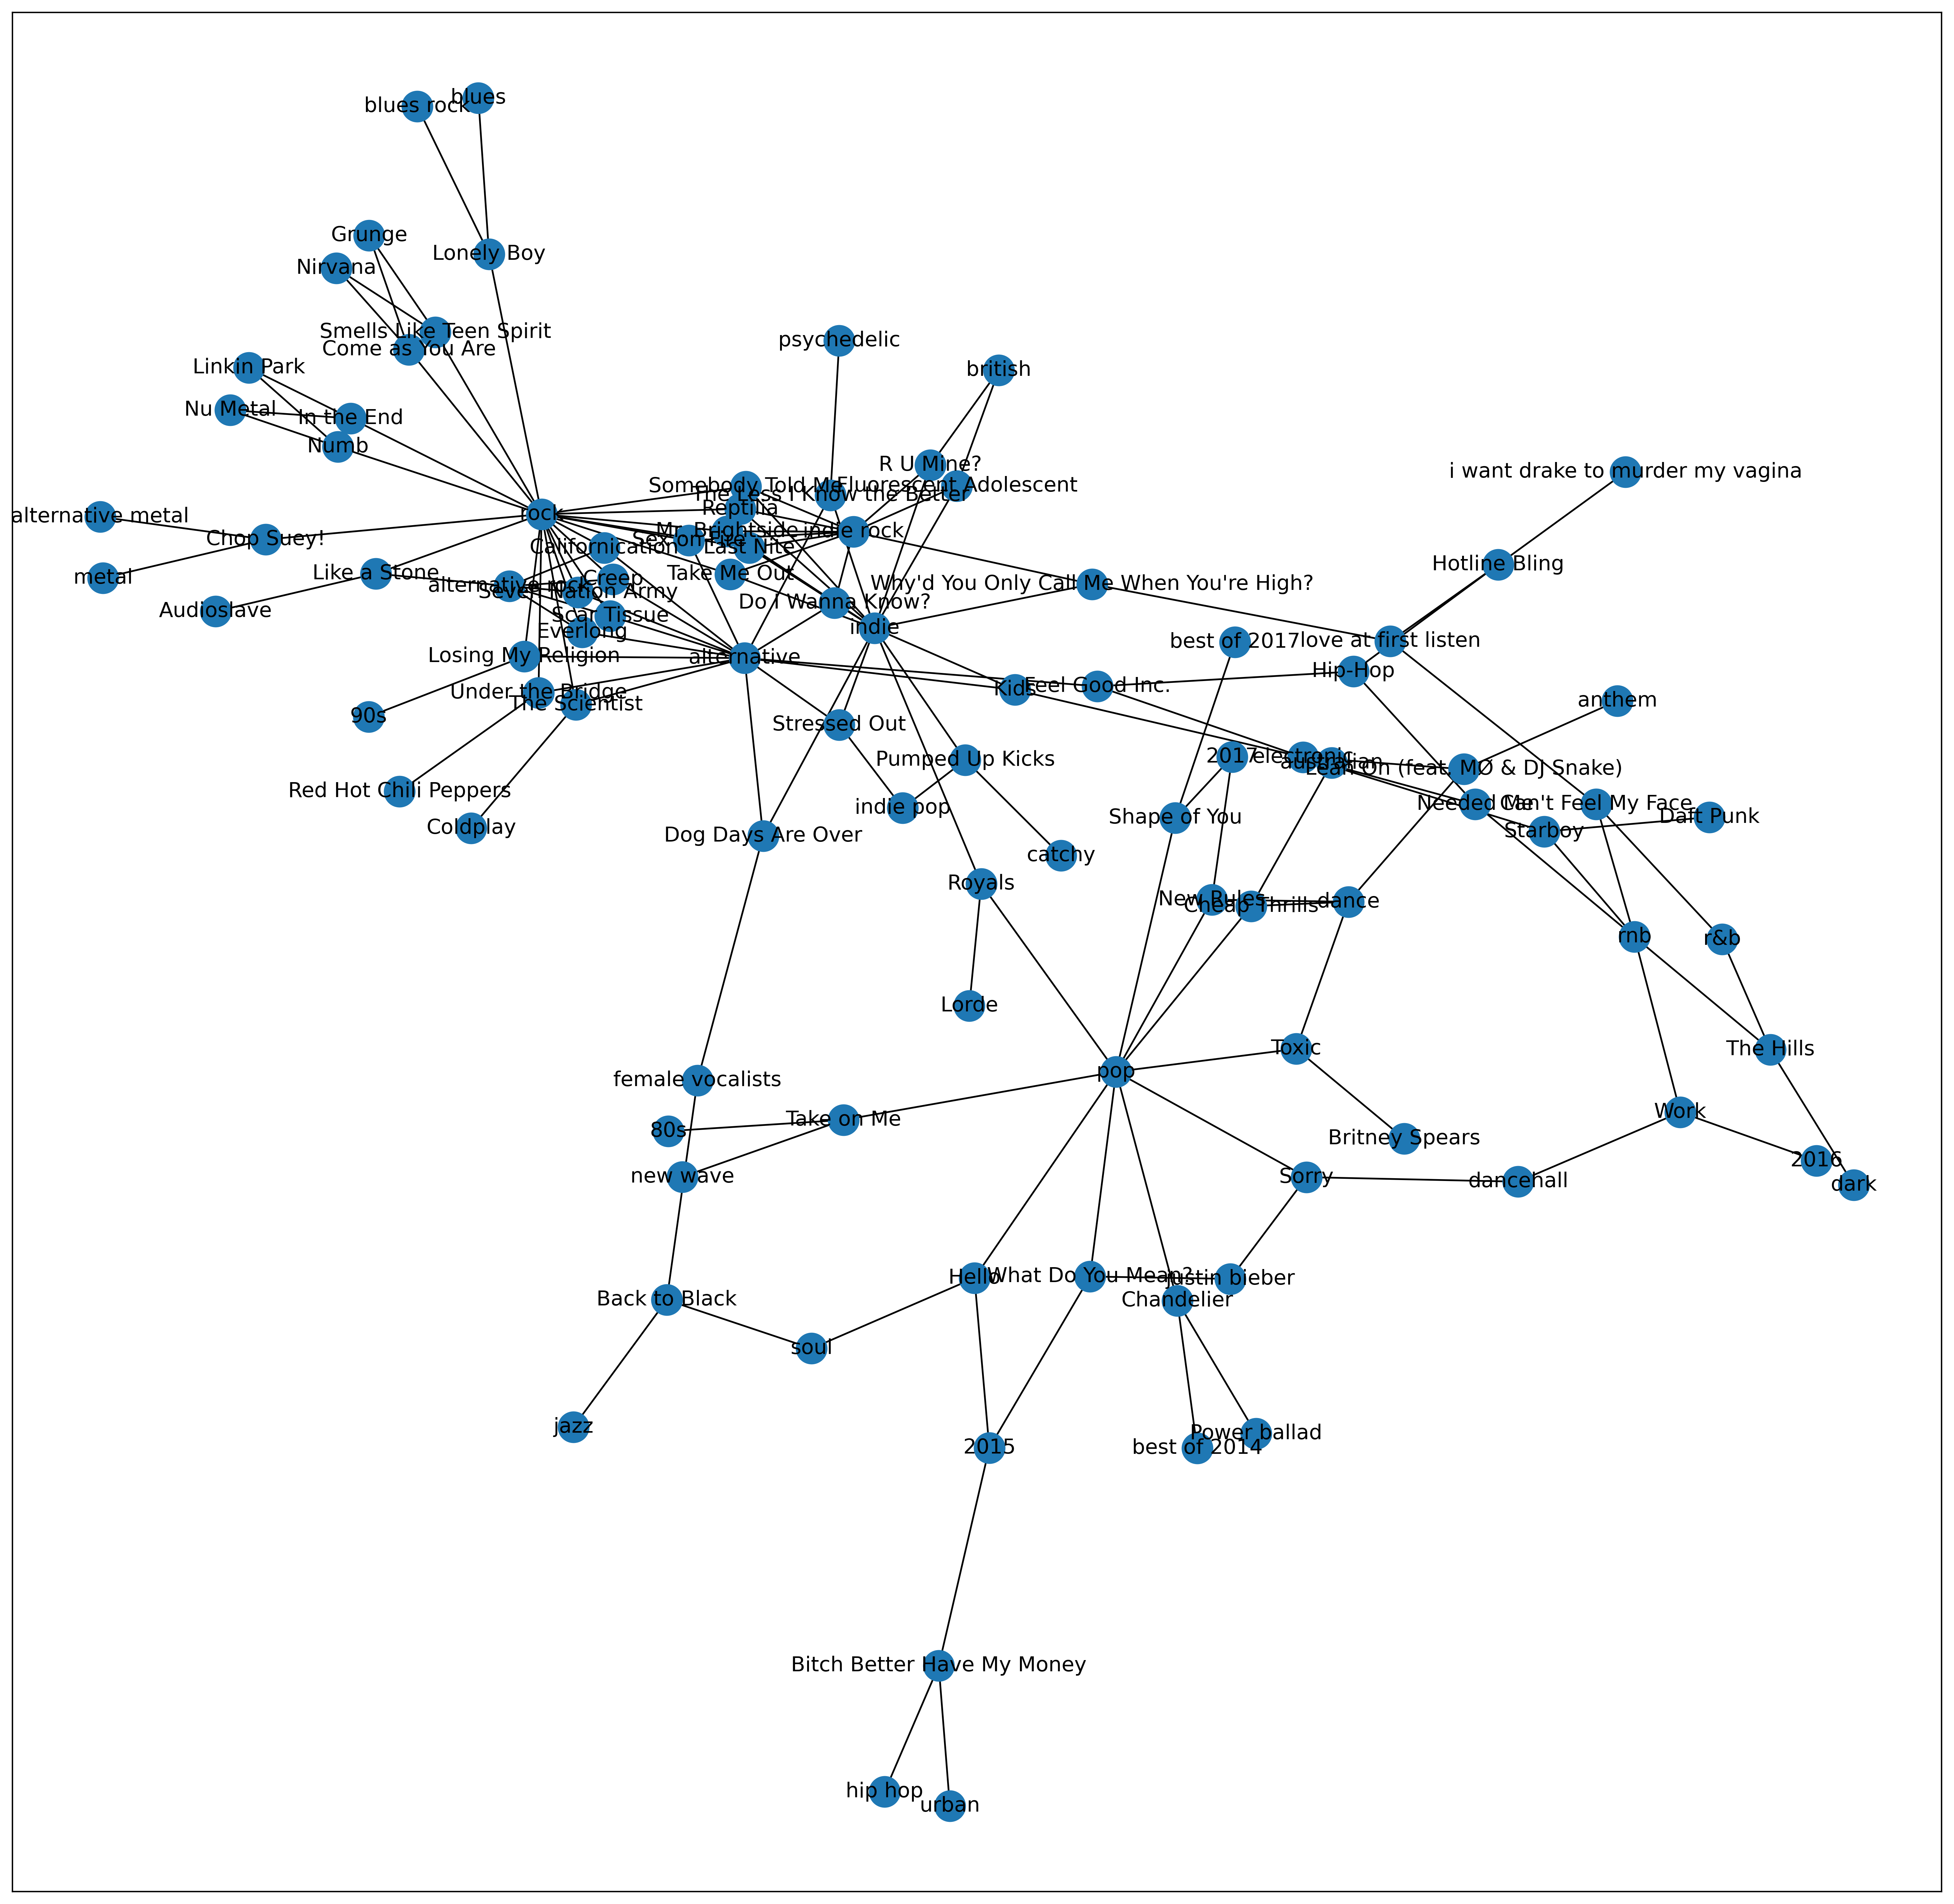

In [5]:
_graph = nx.Graph()

_graph.add_nodes_from(list(songs_graph.keys()))

for node in list(songs_graph.keys()):
    for edge in songs_graph[node]:
        _graph.add_edge(node,edge)
        
plt.figure(num=1,figsize=(20,20),dpi=400)

nx.draw_networkx(_graph)
plt.show()

#### Grafo bipartido

Como este grafo é constituido de dois tipos de dados distintos (músicas e tags) e não existem relações entre nós do mesmo tipo, era de se esperar que se formaria um grafo bipartido. Algo que podemos confirmar


In [6]:
def is_bipartide(G, start):
    '''
    Recebe o grafo e um ponto de inicio. 
    Baseando-se no algoritmo da BFS retorna verdadeiro caso o grafo seja bipartido
    Isso é feito guardando as camadas dos nós e procurando por relações entre nós de mesma camada
    '''

    if start not in G:
        return False
    
    level = 0  
    nextlevel = [start]  
    explored = {start: level}  
    while nextlevel:
        level = level + 1
        thislevel = nextlevel
        nextlevel = []
        for v in thislevel:
            for w in G[v]:
                if w not in explored:
                    explored[w] = level
                    nextlevel.append(w)
                elif explored[w] == explored[v]:
                    return False

    return True

print(is_bipartide(songs_graph, 'Do I Wanna Know?'))

True


#### Visualização do grafo bipartido
As bibliotecas anteriormente citadas também nos permitem ter uma visualização diferente do grafo.
Tendo em mente o fato do mesmo ser bipartido.
Através da imagem abaixo, é possível ver que temos todas as músicas na esquerda e todas as categorias na direita. Além disso, as relações acontecem apenas entre os lados. Não existem linhas entre duas categorias nem linhas entre duas músicas.

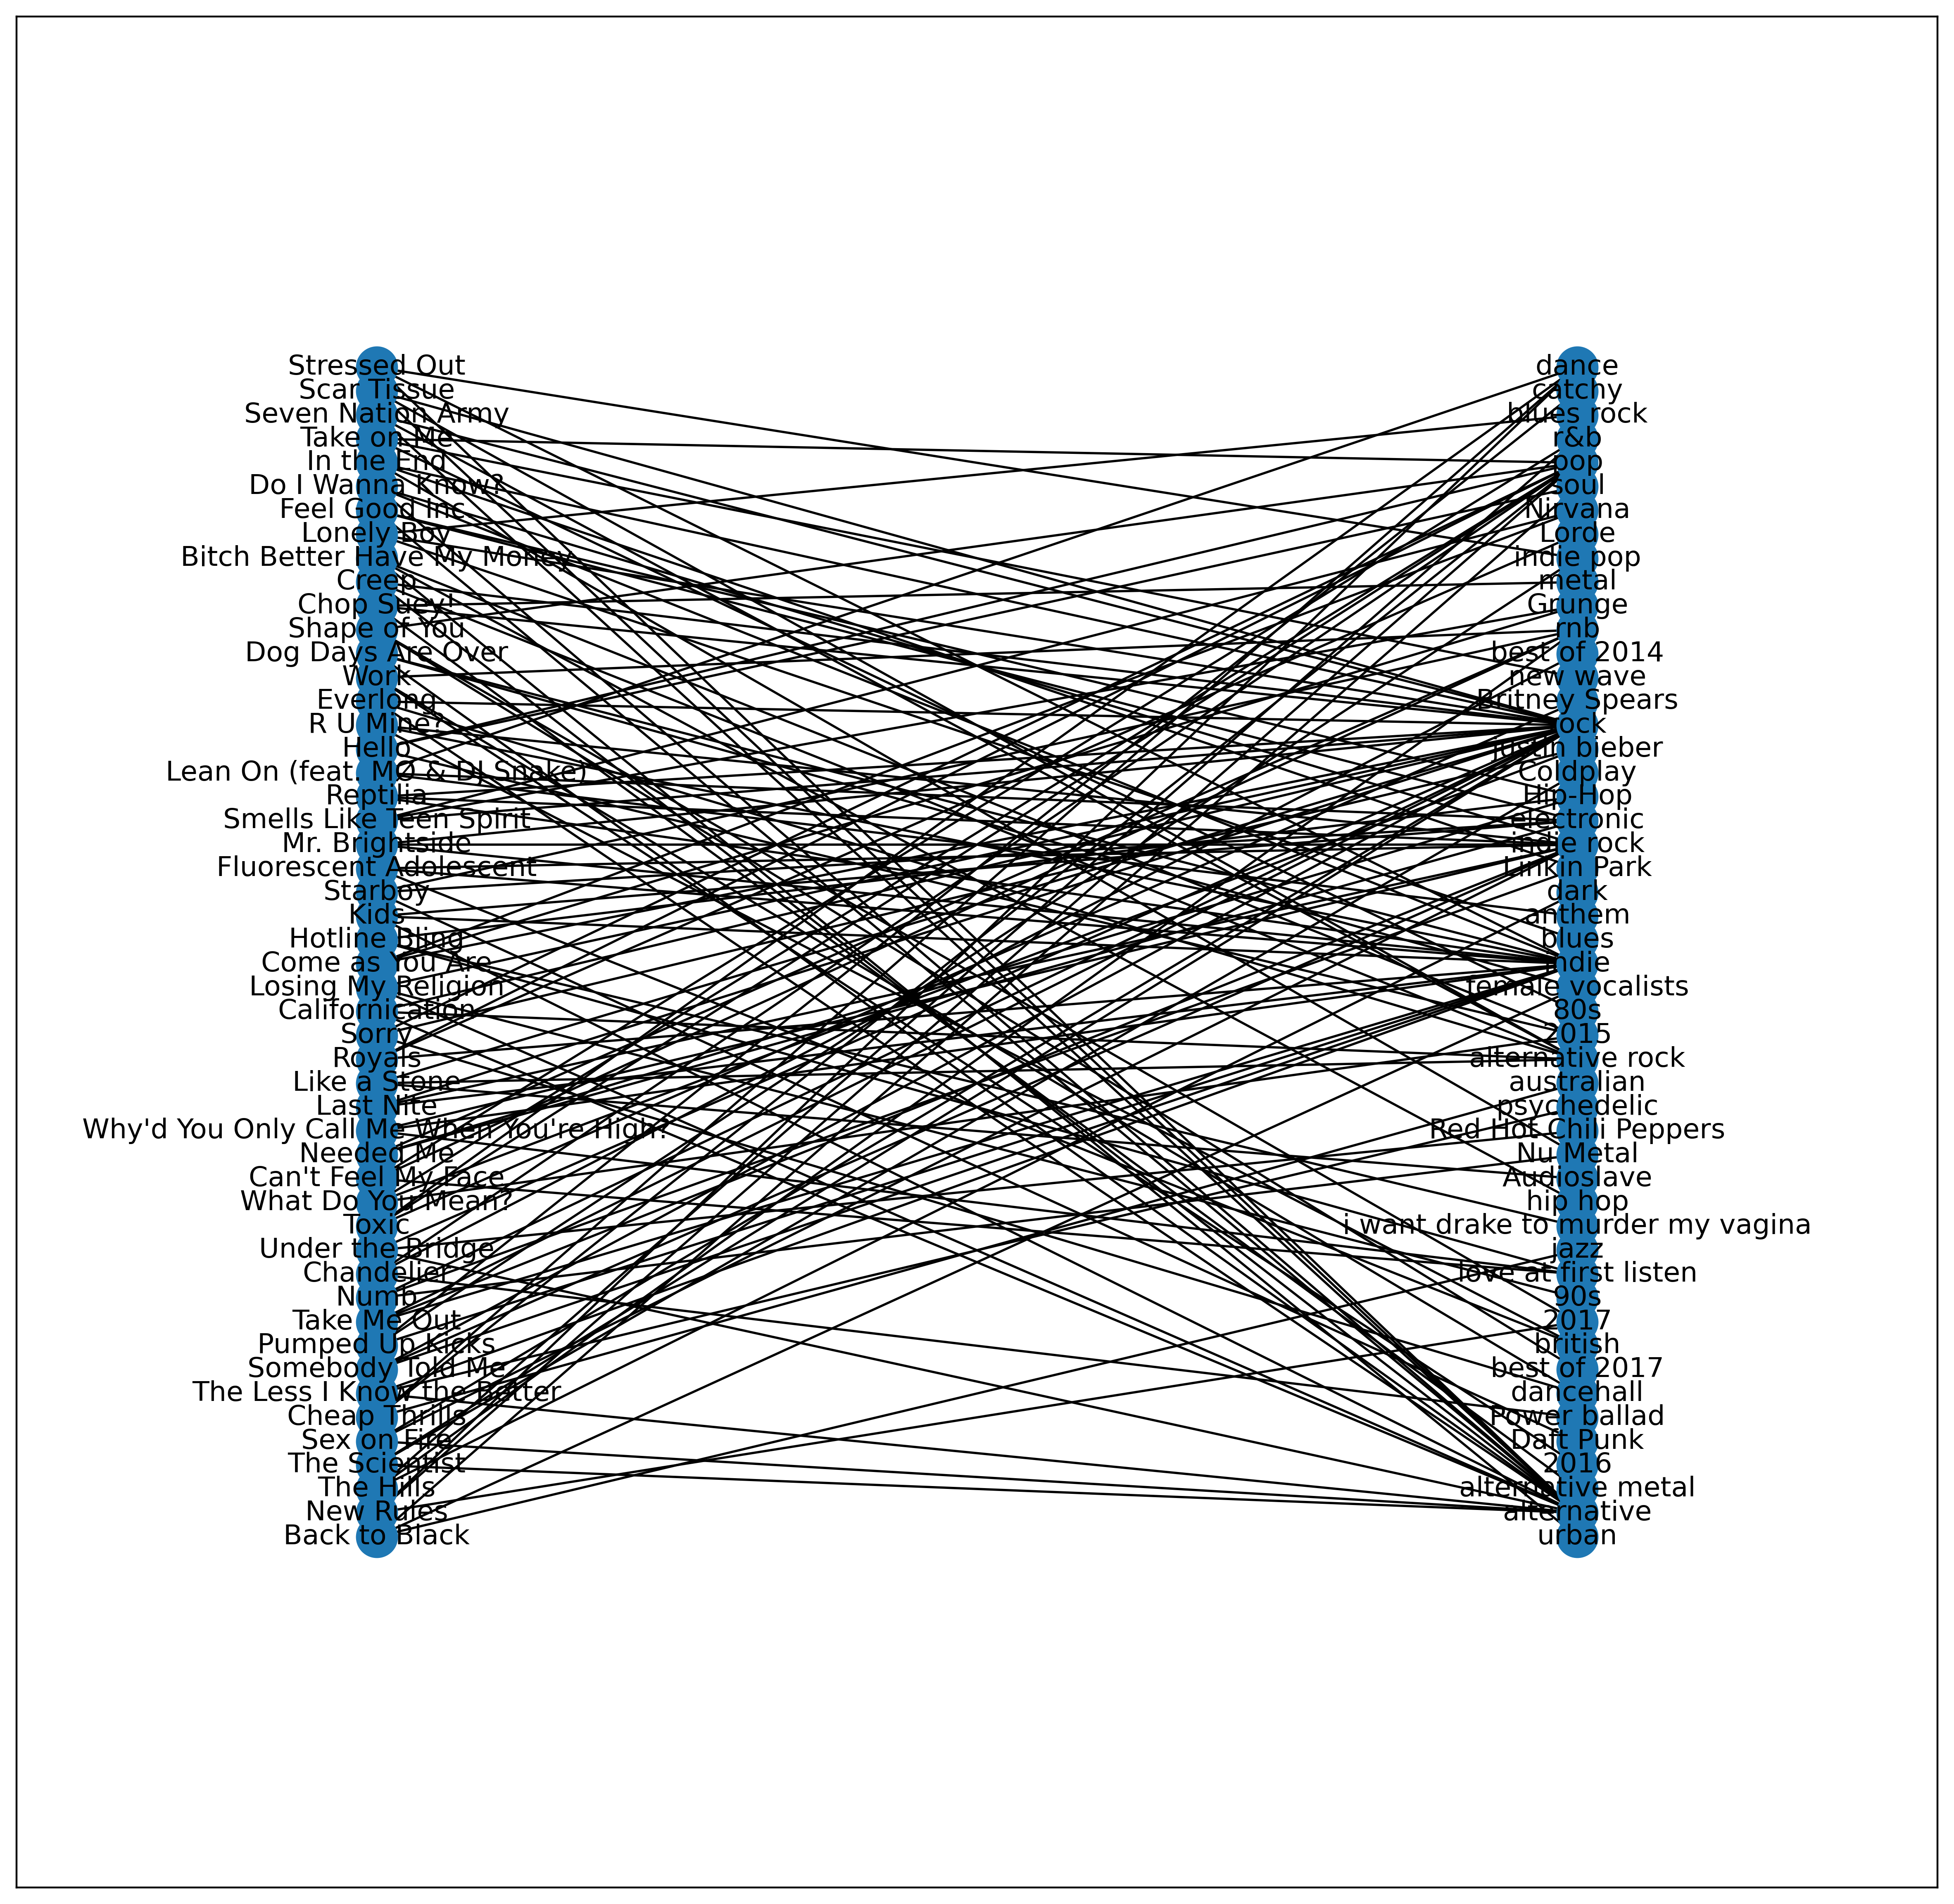

In [7]:
plt.figure(num=1,figsize=(15,15),dpi=400)
plt.margins(0.3)
nx.draw_networkx(
    _graph,
    pos = nx.drawing.layout.bipartite_layout(_graph, songs_list))
plt.show()

#### Agora, para prosseguir basta que o usuário informe uma música que goste
Com isso, pesquisamos na API pela música e ao encontrar podemos inserir ela e suas categorias no grafo

In [8]:

#pede a música e continua pedindo caso a música desejada não tenha sido encontrada
while True:
    song_name = input("Diga uma música que você gosta")
    result = lastfm_request(1,track=song_name)
    if result['results']['trackmatches']['track'] != []:
        break
    print('Musica nao encontrada, tente outra por favor')
        
#Pega o resultado
result = result['results']['trackmatches']['track'][0]

print(f"Resultado: {result['name']} de {result['artist']}")

#Pega as tags da música encontrada
tags = lastfm_request(0,result['artist'],result['name'])['toptags']['tag'][:3]

#Adiciona a musica no grafo
if result['name'] not in songs_graph:
        songs_graph[result['name']] = []
        songs_list.append(result['name'])
        for tag in tags:
            songs_graph[result["name"]].append(tag["name"])
            if tag["name"] not in songs_graph:
                tags_list.append(tag["name"])
                songs_graph[tag["name"]] = [result["name"]]
            else:
                songs_graph[tag["name"]].append(result["name"])
                


Diga uma música que você gostaUndisclosed desires
Resultado: Undisclosed Desires de Muse


#### Agora precisamos descobrir quais são as melhores recomendações para o usuário
Para isso, a ideia é sugerir as músicas com maior número de menores caminhos até a música que o usuário gosta. 

A primeira estratégia pensada para tal foi utilizar uma DFS para construir todos os caminhos de todos os nós até o nó desejado e então computar quais seriam os mais curtos para cada um deles. 

Para um grafo muito pequeno essa estratégia funciona bem, mas obviamente é muito ineficiente. E conforme o grafo cresce isso leva um tempo absurdo. Portanto, foi uma estratégia abandonada

In [ ]:
%%time

#gerando todos os caminhos com a dfs
def dfs_caminhos(grafo, inicio, fim):
    pilha = [(inicio, [inicio])]
    depth = 0
    while pilha:
        vertice, caminho = pilha.pop()
        for proximo in set(grafo[vertice]) - set(caminho):
            if proximo == fim:
                yield caminho + [proximo]
            else:
                pilha.append((proximo, caminho + [proximo]))


best_matches = []

#para cada musica na lista de musicas, guardar o tamanho do menor caminho e o número de menores caminhos
for node in songs_list:
    answers = [len(x) for x in list(dfs_caminhos(songs_graph, node, result['name']))]

    if answers:
        num_paths = answers.count(min(answers))
        path_lenght = min(answers)
        #não consideramos caminhos maiores que 5 pois isso seria uma relação muito distante
        if path_lenght <=5:
            best_matches.append({'name':node,'lenght':path_lenght,'number':num_paths})

#ordena as sugestões priorizando o menor caminho e o número de menores caminhos
best_matches = sorted(best_matches, key=lambda k: (k['lenght'], -k['number']))
best_matches

#### Aqui já temos uma estratégia muito mais refinada 

<br>

1. Primeiro, modificamos um pouco a função de checar se o grafo é bipartido para que ela nos dê um dicionário que contem os "pais" de cada nó. Isto é, seus predecessores. 
2. Depois, utilizamos essa relação de predecessores para encontrar todos os caminhos mais curtos entre um nó inicial e um nó final. 

<br>

Essa estratégia é bem mais eficiente, pois avalia só os caminhos mais curtos e para tal não precisa necessariamente percorrer o grafo todo, basta usar os predecessores. Sendo assim, com esse método levamos um tempo muitas vezes menor para obter nossos resultados.


In [9]:
%%time
def predecessor(G, start):
    '''
        Recebe o grafo e o nó inicial
        Retorna uma  dict de "pais" pra cada nó
    '''
    if start not in G:
        raise False

    level = 0  
    nextlevel = [start]  
    explored = {start: level}  
    pred = {start: []}  
    while nextlevel:
        level = level + 1
        thislevel = nextlevel
        nextlevel = []
        for v in thislevel:
            for w in G[v]:
                if w not in explored:
                    pred[w] = [v]
                    explored[w] = level
                    nextlevel.append(w)
                elif explored[w] == level:  
                    pred[w].append(v)  

    return pred

def find_paths(start, target, pred):
    '''
        Recebe um nó inicial, um nó final e um dicionario contendo os pais de cada nó
        Gera um objeto com todos os menores caminhos entre o nó inicial e o nó final
    '''
    if target not in pred or {target}==start:
        return None

    explored = {target}
    stack = [[target, 0]]
    top = 0
    while top >= 0:
        node, i = stack[top]
        if node in start:
            yield [p for p, n in reversed(stack[: top + 1])]
        if len(pred[node]) > i:
            stack[top][1] = i + 1
            next = pred[node][i]
            if next in explored:
                continue
            else:
                explored.add(next)
            top += 1
            if top == len(stack):
                stack.append([next, 0])
            else:
                stack[top][:] = [next, 0]
        else:
            explored.discard(node)
            top -= 1


best_matches = []

#para cada musica na lista de musicas, guardar o tamanho do menor caminho e o número de menores caminhos
for node in songs_list:
    parentage = predecessor(songs_graph, node)
    paths = list(find_paths({node}, result['name'], parentage))
    if paths != []:
        num_paths = len(paths)
        path_lenght = len(paths[0])
        
        #não consideramos caminhos com comprimento maior que 5 pois isso seria uma relação muito fraca.
        if path_lenght <=5:
            best_matches.append({'name':node,'lenght':path_lenght,'number':num_paths})

#ordenamos as sugestões por comprimento do caminho mais curto e quantidade de caminhos mais curtos
best_matches = sorted(best_matches, key=lambda k: (k['lenght'], -k['number']))
best_matches

    

CPU times: user 7.72 ms, sys: 0 ns, total: 7.72 ms
Wall time: 7.01 ms


[{'name': 'Seven Nation Army', 'lenght': 3, 'number': 3},
 {'name': 'Creep', 'lenght': 3, 'number': 3},
 {'name': 'Californication', 'lenght': 3, 'number': 3},
 {'name': 'Everlong', 'lenght': 3, 'number': 3},
 {'name': 'Scar Tissue', 'lenght': 3, 'number': 3},
 {'name': 'Losing My Religion', 'lenght': 3, 'number': 2},
 {'name': 'Under the Bridge', 'lenght': 3, 'number': 2},
 {'name': 'Sex on Fire', 'lenght': 3, 'number': 2},
 {'name': 'The Scientist', 'lenght': 3, 'number': 2},
 {'name': 'Like a Stone', 'lenght': 3, 'number': 2},
 {'name': 'Do I Wanna Know?', 'lenght': 3, 'number': 1},
 {'name': 'Mr. Brightside', 'lenght': 3, 'number': 1},
 {'name': 'Smells Like Teen Spirit', 'lenght': 3, 'number': 1},
 {'name': 'The Less I Know the Better', 'lenght': 3, 'number': 1},
 {'name': 'Take Me Out', 'lenght': 3, 'number': 1},
 {'name': 'Come as You Are', 'lenght': 3, 'number': 1},
 {'name': 'In the End', 'lenght': 3, 'number': 1},
 {'name': 'Last Nite', 'lenght': 3, 'number': 1},
 {'name': 'R

#### Tudo pronto, agora basta mostrarmos as recomendações, em ordem de mais provável para menos provável

In [18]:
from IPython.core.display import display, HTML
display(HTML(f'<h1>Suas recomendações são:</h1>'))
for match in best_matches:
    display(HTML(f'<a style="font-size: 18px;" href={song_links.get(match.get("name"))}>{match.get("name")}</a>'))

#### Extra:
Além desse notebook, que percorre o código de forma bem explicativa, temos também um frontend construído em flask pelo qual você pode utilizar o programa. Para acessar basta seguir as instruções do readme ou do vídeo instru

<img style="max-width: 800px" src="tela1.png">
<img style="max-width: 800px" src="tela2.png">